In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation,MaxPooling2D,Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,LearningRateScheduler,CSVLogger,LambdaCallback,TensorBoard
from tensorflow.keras import regularizers
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.regularizers import l2
import seaborn as sns
from pathlib import Path
import math
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
dristi_data_dir = '/content/drive/MyDrive/dristygs/Drishti-GS1/Drishti-GS1'

In [ ]:
split_output_dir = "/content/drive/MyDrive/Eye Glaucoma/drishtri_data/"
Path(split_output_dir).mkdir(parents=True, exist_ok=True)

# New Section

In [ ]:
train_dir = "/content/drive/MyDrive/Eye Glaucoma/drishtri_data/train"
val_dir = "/content/drive/MyDrive/Eye Glaucoma/drishtri_data/val"
test_dir = "/content/drive/MyDrive/Eye Glaucoma/drishtri_data/test"

In [ ]:
if Path(train_dir).exists() and Path(val_dir).exists() and Path(test_dir).exists():
    print("===========Directory Already Exists==================")
    pass
else:
    print("==================Directory Created=================")
    splitfolders.ratio(dristi_data_dir, output=split_output_dir, seed=1337, ratio=(.8, 0.1,0.1))

==================Directory Created=================


Copying files: 6003 files [02:53, 34.50 files/s] 


In [ ]:
train_gen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    channel_shift_range=10.,
    fill_mode="nearest"
)
gen = ImageDataGenerator()

In [ ]:
train_batches = train_gen.flow_from_directory(directory=train_dir, target_size=(224,224),
    classes=['Glaucoma', 'Normal'], batch_size=32)

valid_batches = ImageDataGenerator().flow_from_directory(directory=val_dir, target_size=(224,224),
    classes=['Glaucoma', 'Normal'], batch_size=32)

test_batches = ImageDataGenerator().flow_from_directory(directory=test_dir, target_size=(224,224),
    classes=['Glaucoma', 'Normal'], batch_size=32,shuffle=False)

Found 4802 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


In [ ]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 1.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    plt.style.use('ggplot')
    cols = len(ims)/rows
    #cols = 8
    for i in range(len(ims)):
    #for i in range(10):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


In [ ]:
vgg19_model = VGG19()
#vgg16_model = VGG16()
model_vgg19 = Sequential()
for layer in vgg19_model.layers[:-1]:
    model_vgg19.add(layer)
for layer in model_vgg19.layers:
    layer.trainable = False

model_vgg19.add(Dense(2, activation='sigmoid'))


mcp_save = ModelCheckpoint('/content/drive/MyDrive/Eye Glaucoma/models/eye_ckpt_vgg19.h5', save_best_only=True, monitor='val_loss', mode='auto')

earlyStopping = EarlyStopping(monitor='val_loss',min_delta=0,verbose=1,mode='auto',baseline=None,patience=10,restore_best_weights=True)

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4,mode='auto')

574710816/574710816 [==============================] - 25s 0us/step


In [ ]:
callbacks_list = [mcp_save,reduce_lr_loss, earlyStopping]

In [ ]:
if os.path.isfile('/content/drive/MyDrive/Eye Glaucoma/models/eye_ckpt_vgg19.h5'):
    #This code is implemented to load the partly trained model which was stopped due to some reason
    print("Running the Partially Trained Model")
    partially_trained_model = load_model('/content/drive/MyDrive/Eye Glaucoma/models/eye_ckpt_vgg19.h5')
    history = partially_trained_model.fit(train_batches, steps_per_epoch=len(train_batches),
                                 validation_data=valid_batches, validation_steps=len(valid_batches),
                                    epochs=50,callbacks=callbacks_list, verbose=1)
else:
    print("Running the Training of Model from Scratch")
    model_vgg19.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
    history = model_vgg19.fit(train_batches, steps_per_epoch=len(train_batches),
                                 validation_data=valid_batches, validation_steps=len(valid_batches),
                                    epochs=50,callbacks=callbacks_list, verbose=1)

Running the Training of Model from Scratch
Epoch 1/50
151/151 [==============================] - 95s 547ms/step - loss: 0.4646 - accuracy: 0.8203 - val_loss: 0.2700 - val_accuracy: 0.9450 - lr: 1.0000e-04
Epoch 2/50
151/151 [==============================] - 77s 512ms/step - loss: 0.2486 - accuracy: 0.9323 - val_loss: 0.1727 - val_accuracy: 0.9533 - lr: 1.0000e-04
Epoch 3/50
151/151 [==============================] - 78s 514ms/step - loss: 0.1905 - accuracy: 0.9467 - val_loss: 0.1326 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 4/50
151/151 [==============================] - 79s 520ms/step - loss: 0.1564 - accuracy: 0.9540 - val_loss: 0.1088 - val_accuracy: 0.9767 - lr: 1.0000e-04
Epoch 5/50
151/151 [==============================] - 78s 513ms/step - loss: 0.1327 - accuracy: 0.9648 - val_loss: 0.0926 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 6/50
151/151 [==============================] - 89s 592ms/step - loss: 0.1159 - accuracy: 0.9711 - val_loss: 0.0834 - val_accuracy: 0.9750 - 

Plot Loss Accuracy Curve

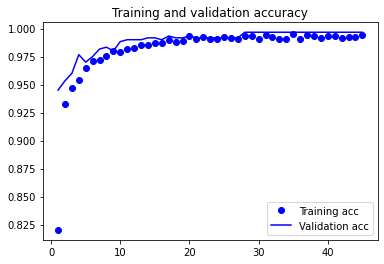

<Figure size 432x288 with 0 Axes>

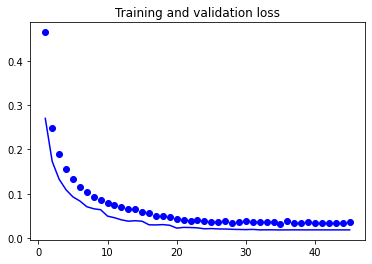

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
f,ax = plt.subplots(figsize=(6, 4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
os.makedirs("/content/drive/MyDrive/Eye Glaucoma/Figures");
plt.savefig('/content/drive/MyDrive/Eye Glaucoma/Figures/accuracy.png')
plt.figure()
f,ax = plt.subplots(figsize=(6, 4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.savefig('/content/drive/MyDrive/Eye Glaucoma/Figures/loss.png')
plt.show()

In [ ]:
def plot_curve(history,fig_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10,10))
    plt.grid()
    plt.title('Training and validation Curve')
    plt.plot(epochs, acc, 'b',marker='o', label='Training acc')
    plt.plot(epochs, val_acc, 'r',marker='o', label='Validation acc')
    plt.legend()

    plt.plot(epochs, loss, 'm',marker='o', label='Training loss')
    plt.plot(epochs, val_loss, 'g',marker='o', label='Validation loss')
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/Eye Glaucoma/Figures/{fig_name}.png")
    plt.show()


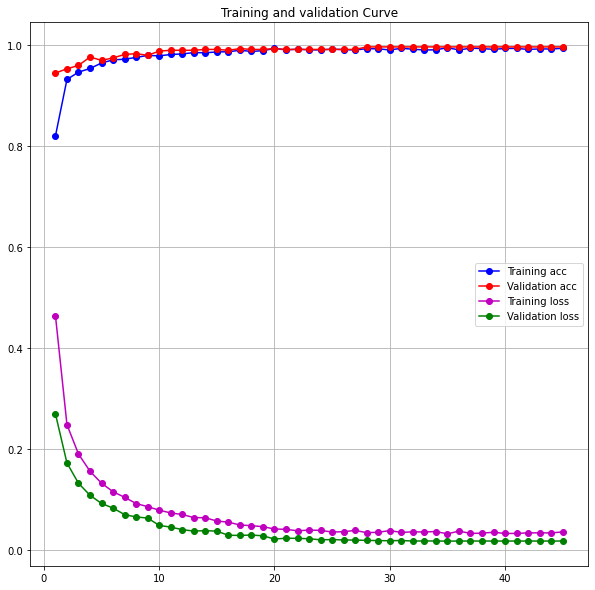

In [ ]:
plot_curve(history,"acc_loss_curve")

Model Prediction and Confusion matrix

In [ ]:
# model_vgg19 = load_model('/content/drive/MyDrive/freelance/models/eye_ckpt_vgg19.h5')
model_vgg19 = load_model('/content/drive/MyDrive/Eye Glaucoma/models/eye_ckpt_vgg19.h5')

19/19 [==============================] - 6s 290ms/step


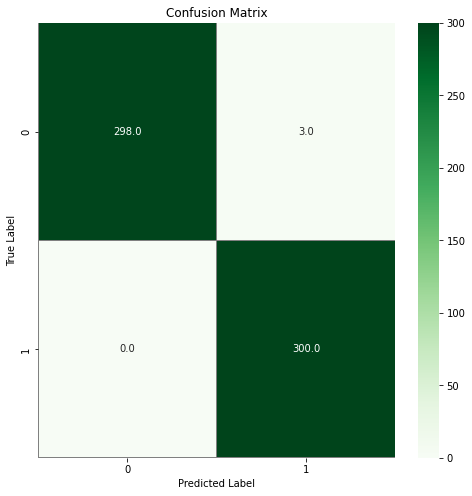

In [ ]:
predictions = model_vgg19.predict(test_batches, steps=len(test_batches), verbose=1)
pred_label = np.argmax(predictions,axis=1)
classes = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_batches.labels,pred_label)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/Eye Glaucoma/Figures/confusion_matrix_dist.png')
plt.show()

In [ ]:
import pandas as pd
class_names = ['Glaucoma', 'Normal']

def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    cm = pd.DataFrame(cm, index=[i for i in class_names],
                  columns = [i for i in class_names])

    cm.index.name = 'True label'
    cm.columns.name = 'Predicted label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig('/content/drive/MyDrive/Eye Glaucoma/Figures/confusion_matrix_dist.png')

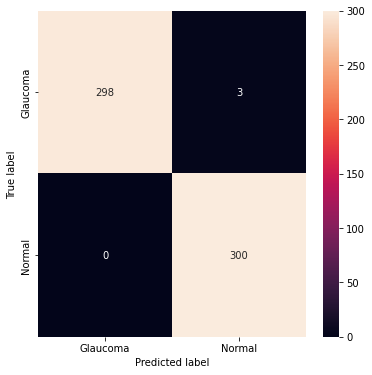

In [ ]:
plot_cm(test_batches.labels,pred_label)

Model Evaluation on test data

In [ ]:
score = model_vgg19.evaluate(train_batches)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

151/151 [==============================] - 69s 457ms/step - loss: 0.0375 - accuracy: 0.9910
Train loss: 0.037540215998888016
Train accuracy: 0.9910454154014587


In [ ]:
score = model_vgg19.evaluate(valid_batches)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

19/19 [==============================] - 3s 162ms/step - loss: 0.0181 - accuracy: 0.9967
Validation loss: 0.018113847821950912
Validation accuracy: 0.996666669845581


In [ ]:
score = model_vgg19.evaluate(test_batches)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

19/19 [==============================] - 3s 162ms/step - loss: 0.0229 - accuracy: 0.9950
Test loss: 0.02292078547179699
Test accuracy: 0.9950082898139954


Classification Report

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_batches.classes, pred_label, target_names=class_names))


              precision    recall  f1-score   support

    Glaucoma       1.00      0.99      0.99       301
      Normal       0.99      1.00      1.00       300

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601

